In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from py_helpers.db_helper import *

In [2]:
target = 'playoff'
cleaned_data = './db/WNBA_cleared.db'
filtered_data = './db/WNBA_filtered.db'
tables = ['Awards_Players', 'Coaches', 'Players', 'Players_Teams', 'Teams', 'Teams_Year']

In [3]:
# Retrieve data from the tables in the database
awards_players_df = retrieve_data(cleaned_data, tables[0])  
coaches_df = retrieve_data(cleaned_data, tables[1])  
players_df = retrieve_data(cleaned_data, tables[2])  
players_teams_df = retrieve_data(cleaned_data, tables[3])  
teams_df = retrieve_data(cleaned_data, tables[4])  
teams_year_df = retrieve_data(cleaned_data, tables[5])  


In [4]:
# Feature Selection based on domain knowledge (not using 'pos' playoffs values)

# Features to use for the Players_Team table
features_player_teams = ['playerID','year','stint','tmID','GP','GS','minutes','points','oRebounds','dRebounds','rebounds','assists','steals','blocks','turnovers','PF','fgRatio','ftRatio','threeRatio','dq']
players_teams_df = players_teams_df[features_player_teams]

players_teams_df['p_stint'] = players_teams_df['stint']
players_teams_df = players_teams_df.drop(['stint'], axis=1)


table_name = tables[3]
schema = schema_builder(players_teams_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(players_teams_df, table_name, filtered_data, schema)

In [5]:
# Features to use for the Coaches table
features_coaches = ["coachID","year","tmID","stint","won","lost"]
coaches_df = coaches_df[features_coaches]

coaches_df['c_stint'] = coaches_df['stint']
coaches_df = coaches_df.drop(columns=['stint'])

table_name = tables[1]
schema = schema_builder(coaches_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(coaches_df, table_name, filtered_data, schema)

In [6]:
# Features to use for the Teams table
features_teams = ['year','tmID','rank','playoff',
                  'o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts',
                  'd_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts',
                  'homeW','homeL','awayW','awayL'] #+ ['won', 'lost', 'attend']
teams_df = teams_df[features_teams]

# create a new column 'last_year_rank' and set it to NaN
teams_df['last_year_rank'] = np.nan

# loop through each year from 1 to 10
for year in range(1, 11):
    # get the rows for the current year
    current_year_rows = teams_df[teams_df['year'] == year]
    
    # get the rows for the previous year
    previous_year_rows = teams_df[teams_df['year'] == year - 1]
    
    # loop through each team in the current year
    for index, row in current_year_rows.iterrows():
        # get the team ID for the current row
        team_id = row['tmID']
        
        # get the row for the same team in the previous year
        previous_year_row = previous_year_rows[previous_year_rows['tmID'] == team_id]
        
        # if there is a previous year row, set the last year rank to the rank from the previous year
        if not previous_year_row.empty:
            teams_df.at[index, 'last_year_rank'] = previous_year_row.iloc[0]['rank']
        else: # if there is no previous year row, set the last year rank to 10
            teams_df.at[index, 'last_year_rank'] = 10

table_name = tables[4]
schema = schema_builder(teams_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(teams_df, table_name, filtered_data, schema)

In [7]:
# Features to use for the Players table
features_player = ['bioID','pos','height','weight','birthDate']

# Selecting features for teams_df
players_df = players_df[features_player]

# Replacing invalid dates with NaN
players_df['birthDate'] = players_df['birthDate'].replace('0000-00-00', np.nan)

# Converting to birthYear and dropping birthDate
players_df['birthYear'] = pd.to_datetime(players_df['birthDate']).dt.year
players_df['birthYear'] = players_df['birthYear'].astype('Int64')
players_df.drop('birthDate', axis=1, inplace=True)

# One-hot encoding for 'pos'
players_df = pd.get_dummies(players_df, columns=['pos'])
players_df.columns = players_df.columns.str.replace(' ', '_')
players_df.columns = players_df.columns.str.replace('-', '_')

# Change bioID to playerID
players_df = players_df.rename(columns={'bioID': 'playerID'})

table_name = tables[2]
schema = schema_builder(players_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(players_df, table_name, filtered_data, schema)

players_df.head()

,playerID,height,weight,birthYear,pos_C,pos_C_F,pos_F,pos_F_C,pos_F_G,pos_G,pos_G_F
0,abrahta01w,74.0,190,1975,True,False,False,False,False,False,False
1,abrossv01w,74.0,169,1980,False,False,True,False,False,False,False
2,adairje01w,76.0,197,1986,True,False,False,False,False,False,False
3,adamsda01w,73.0,239,1989,False,False,False,True,False,False,False
4,adamsjo01w,75.0,180,1981,True,False,False,False,False,False,False


In [8]:
# Selecting features for Awards_Players table
# Removed 'Coach of the Year' because it is not a player award
features_awards_players = ['playerID','year','All-Star Game Most Valuable Player','Defensive Player of the Year', 'Kim Perrot Sportsmanship Award','Most Improved Player','Most Valuable Player','Rookie of the Year','Sixth Woman of the Year','WNBA All Decade Team Honorable Mention','WNBA All-Decade Team','WNBA Finals Most Valuable Player']
 
# Replace spaces with underscores in the column names
for i in range(len(features_awards_players)):
    features_awards_players[i] = features_awards_players[i].replace(' ', '_')
    features_awards_players[i] = features_awards_players[i].replace('-', '_')

# Selecting features for awards_players_df
awards_players_df = awards_players_df[features_awards_players]

# Add feature 'any_award' to awards_players_df
# awards_players_df['any_award'] = awards_players_df[features_awards_players[2:]].notnull().any(axis=1)
# this was not useful because this table only have awards, so all the values are True

combined = {}
# Group by 'playerID' and combine the columns for each feature

for feature in features_awards_players[2:]:
    awards_players_df[feature] = awards_players_df.groupby(['playerID', 'year'])[feature].transform('max')


# Drop duplicate rows
awards_players_df = awards_players_df.drop_duplicates()


table_name = tables[0]
schema = schema_builder(awards_players_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(awards_players_df, table_name, filtered_data, schema)

awards_players_df.head()

,playerID,year,All_Star_Game_Most_Valuable_Player,Defensive_Player_of_the_Year,Kim_Perrot_Sportsmanship_Award,Most_Improved_Player,Most_Valuable_Player,Rookie_of_the_Year,Sixth_Woman_of_the_Year,WNBA_All_Decade_Team_Honorable_Mention,WNBA_All_Decade_Team,WNBA_Finals_Most_Valuable_Player
0,thompti01w,1,1,0,0,0,0,0,0,0,0,0
1,leslili01w,2,1,0,0,0,1,0,0,0,0,1
2,leslili01w,3,1,0,0,0,0,0,0,0,0,1
3,teaslni01w,4,1,0,0,0,0,0,0,0,0,0
4,swoopsh01w,6,1,0,0,0,1,0,0,0,0,0


In [9]:
# Teams_Year table setup

# Reverses one-hot encoding to get the coachID (could be or not useful)
def get_coachID():
    coachID = teams_year_df[teams_year_df.columns.to_list()[7:]].idxmax(axis=1)
    # Drop the one-hot encoded columns
    teams_year_df.drop(teams_year_df.columns.to_list()[6:], axis=1, inplace=True)
    # Add the coachID column to the DataFrame
    teams_year_df['coachID'] = coachID
    teams_year_df.drop('coachID', axis=1, inplace=True)

get_coachID()

table_name = tables[5]
schema = schema_builder(teams_year_df)
schema = f"Create Table {table_name} ({schema})"
insert_dataframe(teams_year_df, table_name, filtered_data, schema)

teams_year_df.head()

,year,tmID,totalPoints,cumulativePoints,totalMinutes,yearlyWins
0,1,ATL,0,0,0,0
1,2,ATL,0,0,0,0
2,3,ATL,0,0,0,0
3,4,ATL,0,0,0,0
4,5,ATL,0,0,0,0


In [10]:
available_dfs = {
    'awards_players' : awards_players_df,
    'coaches' : coaches_df,
    'players' : players_df,
    'players_teams' : players_teams_df,
    'teams' : teams_df,
    'teams_year' : teams_year_df } 


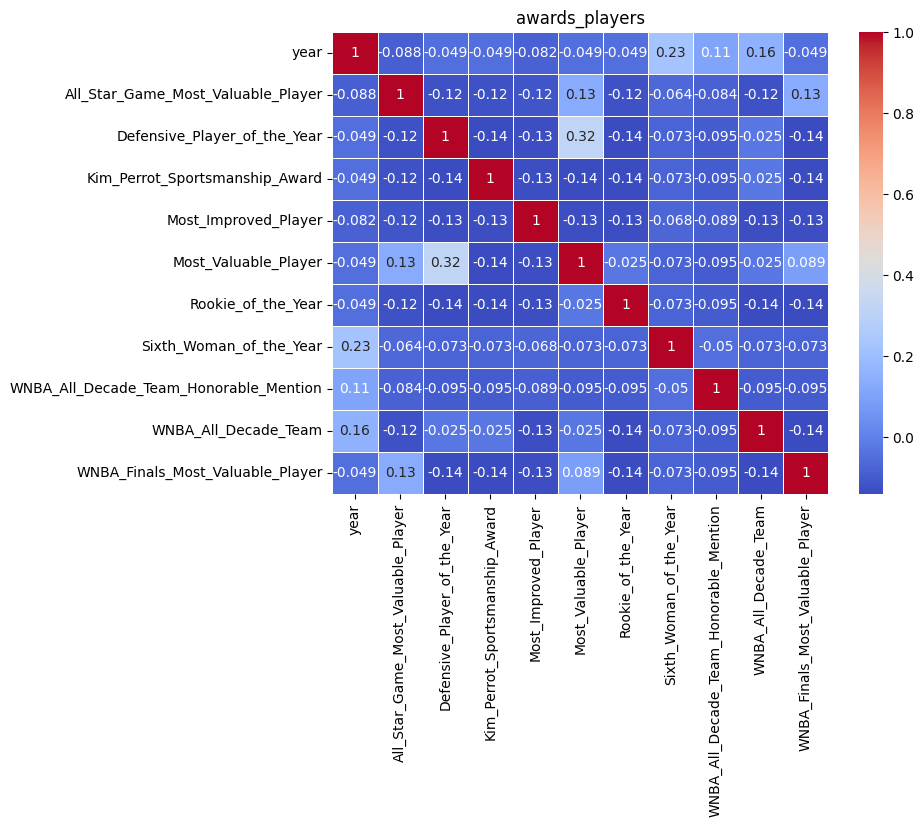

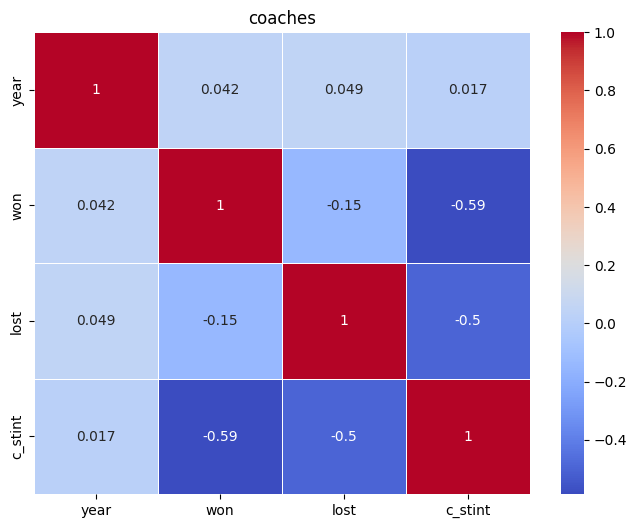

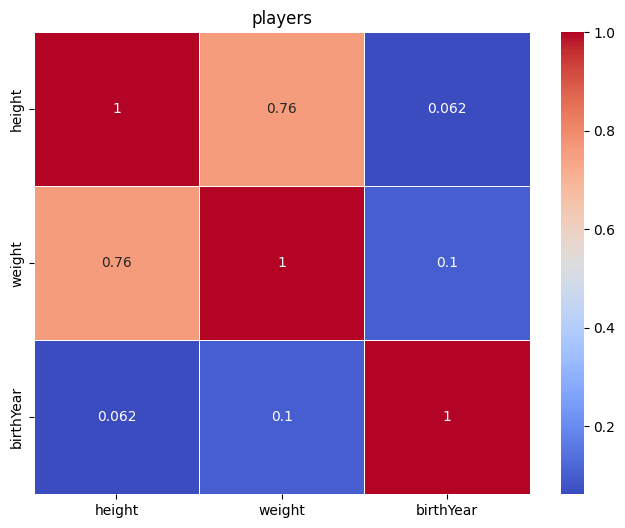

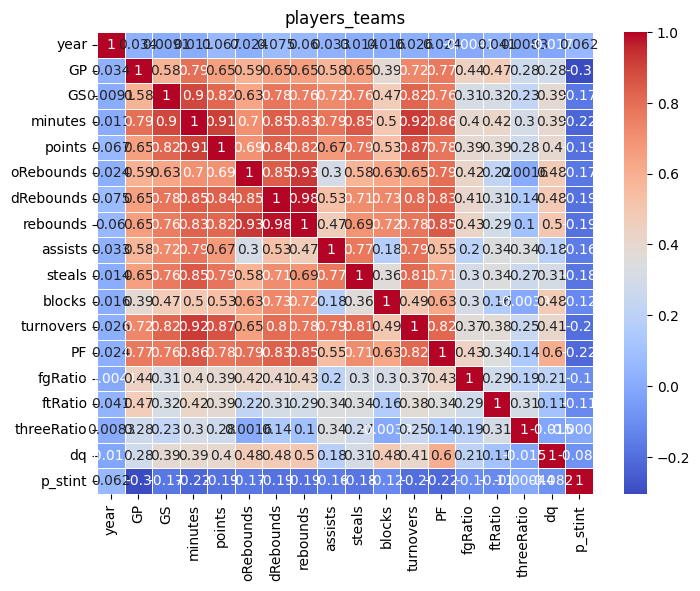

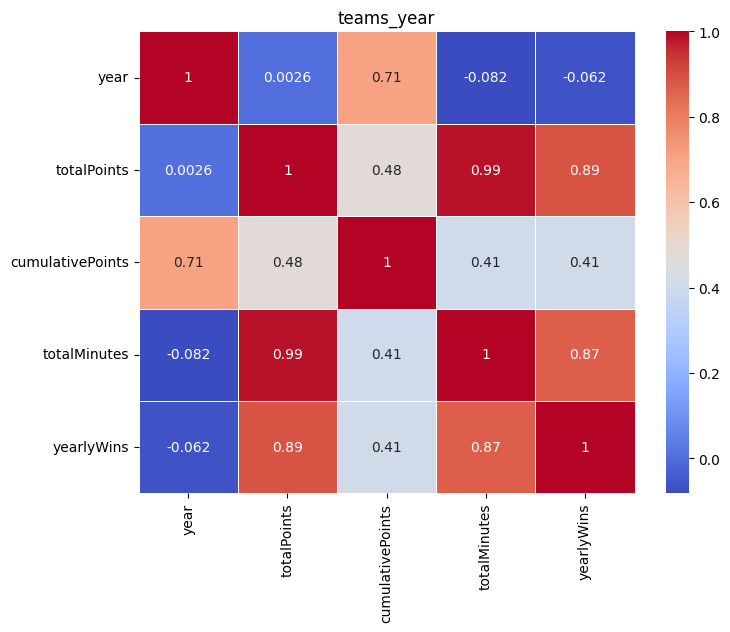

In [11]:
# Removed 'teams' because it has too many columns to be displayed in a heatmap
# 'players_teams' wasn't removed but still hard to read
heatmap_names = ['awards_players', 'coaches', 'players', 'players_teams', 'teams_year'] 

for m in heatmap_names:
    numeric_df = available_dfs[m].select_dtypes(include='number')
    # Compute the correlation matrix
    correlation_matrix = numeric_df.corr()
    # print(correlation_matrix)

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(m)
    plt.show()